In [1]:
import kan
import kan.utils as ku
import numpy as np
import torch.nn as nn
import torch
import qutip as qt
import matplotlib.pyplot as plt
import itertools
from libraries import utils
from libraries import magnetization
from libraries import j1j2_functions

In [2]:
def rfft(x):
    return np.fft.rfft(x)[1:]

In [4]:
hinf12 = j1j2_functions.J1J2_hamiltonian(12, 0, 1)
ginf12 = hinf12.eigenstates()[1][0]

In [5]:
def manual_sr(x, N, shift=0):
    return sum(x[:, (i + shift) % N] + x[:, (i + 1 + shift) % N] for i in range(0, N, 4))
def count_inf_magnetization(state):
    if state == 0: return 0
    return sum(((state >> n) & 1) + ((state >> (n + 1)) & 1) for n in range(0, int(np.log2(state)) + 1, 4))

In [6]:
N=12
states, signs = utils.get_nonzero_states(N, ginf12, 1e-10)
input = utils.generate_input_samples(N, states)
reim_input = []
for x in input: 
    reims = []
    ft = rfft(x)
    for c in ft:
        reims.append(c.real)
        reims.append(c.imag)
    reim_input.append(reims)
reim_input = torch.tensor(reim_input)
print(reim_input.shape)
msr_label = torch.tensor([count_inf_magnetization(s) for s in states]).reshape(-1, 1)
sign_label = torch.tensor(signs).reshape(-1, 1)
print(msr_label.shape, sign_label.shape)
msr_dataset_inf = {'train_input':reim_input, 'train_label':msr_label, 'test_input':reim_input, 'test_label':msr_label}
sign_dataset_inf = {'train_input':reim_input, 'train_label':sign_label, 'test_input':reim_input, 'test_label':sign_label}

torch.Size([400, 12])
torch.Size([400, 1]) torch.Size([400, 1])


In [7]:
sign_model_inf = kan.KAN(width=[12, 12, 1])
sign_model_inf.fit(sign_dataset_inf, lamb=1e-3, steps=50);

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.13e-03 | test_loss: 2.13e-03 | reg: 3.90e+00 | : 100%|█| 50/50 [00:24<00:00,  2.08it

saving model version 0.1


In [8]:
sign_model_inf.prune().width

saving model version 0.2


[[12, 0], [1, 0], [1, 0]]

In [9]:
sign_model_inf = sign_model_inf.prune()
sign_model_inf.fit(sign_dataset_inf, lamb=1e-3, steps=50);

saving model version 0.2


| train_loss: 7.10e-04 | test_loss: 7.10e-04 | reg: 5.60e+00 | : 100%|█| 50/50 [00:10<00:00,  4.94it

saving model version 0.3


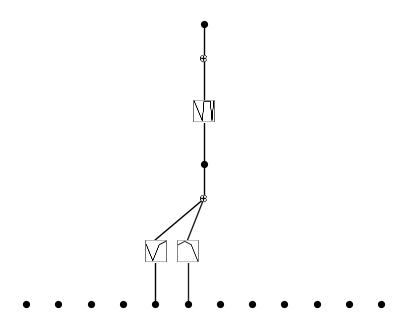

In [10]:
sign_model_inf.plot()

In [11]:
J2 = 0.6024
gs_mid = qt.qload(f'../J1J2_info/large_J2/N{N}/n{N}gs_J2_{J2}')
states, signs = utils.get_nonzero_states(N, gs_mid, 1e-10)
input = utils.generate_input_samples(N, states)
reim_input = []
for x in input: 
    reims = []
    ft = rfft(x)
    for c in ft:
        reims.append(c.real)
        reims.append(c.imag)
    reim_input.append(reims)
reim_input = torch.tensor(reim_input)
print(reim_input.shape)
msr_label = torch.tensor([count_inf_magnetization(s) for s in states]).reshape(-1, 1)
sign_label = torch.tensor(signs).reshape(-1, 1)
print(msr_label.shape, sign_label.shape)
msr_dataset_mid = {'train_input':reim_input, 'train_label':msr_label, 'test_input':reim_input, 'test_label':msr_label}
sign_dataset_mid = {'train_input':reim_input, 'train_label':sign_label, 'test_input':reim_input, 'test_label':sign_label}

torch.Size([924, 12])
torch.Size([924, 1]) torch.Size([924, 1])


In [16]:
sign_mid_kan = kan.KAN(width=[N, N, N, N, 1])
num_steps=200
results = sign_mid_kan.fit(sign_dataset_mid, lamb=0, steps=num_steps);

checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                          | 0/200 [00:00<?, ?it/s]

| train_loss: 3.27e-04 | test_loss: 3.27e-04 | reg: 1.02e+02 | : 100%|█| 200/200 [05:34<00:00,  1.67

saving model version 0.1


In [20]:
torch.save(sign_mid_kan.state_dict(), 'models/kan_j2_0.6024.pt')

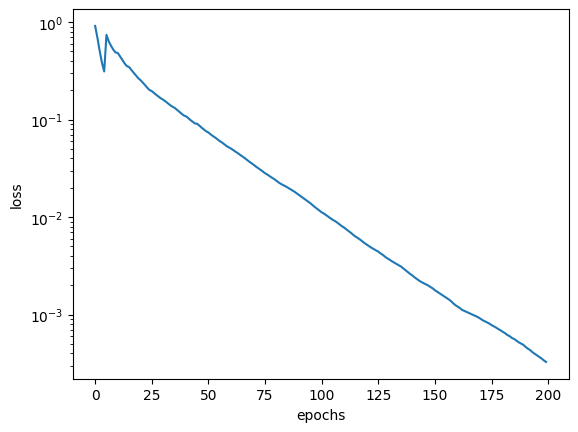

In [18]:
plt.plot(np.arange(num_steps), results['train_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('log')

In [25]:
torch.sqrt(((sign_mid_kan(reim_input).round() - sign_dataset_mid['train_label'])**2).mean()).item()

0.0

In [29]:
sign_mid_kan.saveckpt('models/kan_j2_0.6024_ckpt')

In [26]:
test_load = torch.load('models/kan_j2_0.6024.pt')

In [ ]:
test_load = kan.MultKAN.loadckpt('models/kan_j2_0.6024_ckpt') # use this

In [36]:
print(test_load)
print(torch.sqrt(((test_load(reim_input) - sign_dataset_mid['train_label'])**2).mean()).item())

MultKAN(
  (act_fun): ModuleList(
    (0-3): 4 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-3): 4 x Symbolic_KANLayer()
  )
)
0.000326620414853096


In [67]:
layers = []
layers.append(nn.Linear(N, 32))
layers.append(nn.Tanh())
for _ in range(2):
    layers.append(nn.Linear(32, 32))
    layers.append(nn.Tanh())
layers.append(nn.Linear(32, 1))
layers.append(nn.Tanh())
sign_mid_mlp = nn.Sequential(*layers)

In [68]:
torch.nn.MSELoss()(sign_mid_mlp(sign_dataset_mid['train_input']), sign_dataset_mid['train_label']).dtype

torch.float32

In [69]:
num_steps=10000
optim = torch.optim.Adam(sign_mid_mlp.parameters(), lr=1e-3)
loss_data = []
for epoch in range(num_steps):
    optim.zero_grad()
    def closure():
        optim.zero_grad()
        loss = torch.nn.MSELoss()(sign_mid_mlp(sign_dataset_mid['train_input']), sign_dataset_mid['train_label'].to(dtype=torch.float32)    )
        loss.backward()
        return loss
    optim.step(closure)
    loss = torch.nn.MSELoss()(sign_mid_mlp(sign_dataset_mid['train_input']), sign_dataset_mid['train_label'].to(dtype=torch.float32)    )
    loss_data.append(loss.item())
    if epoch % 50 == 0:
        print(epoch, ':', loss.item())


0 : 1.0576975345611572
50 : 0.9987193942070007
100 : 0.9933410286903381
150 : 0.9456878304481506
200 : 0.6694841980934143
250 : 0.2661171555519104
300 : 0.08211687952280045
350 : 0.031683605164289474
400 : 0.0188214723020792
450 : 0.012367979623377323
500 : 0.010939166881144047
550 : 0.010251598432660103
600 : 0.009846757166087627
650 : 0.009578828699886799
700 : 0.006118086166679859
750 : 0.005086826626211405
800 : 0.004926376044750214
850 : 0.004822010640054941
900 : 0.004746026359498501
950 : 0.00468792300671339
1000 : 0.00464201346039772
1050 : 0.004604857414960861
1100 : 0.004574217367917299
1150 : 0.004548568744212389
1200 : 0.004526828415691853
1250 : 0.004508207086473703
1300 : 0.004492109641432762
1350 : 0.00447808438912034
1400 : 0.004465779289603233
1450 : 0.004454916808754206
1500 : 0.004445272963494062
1550 : 0.004436667542904615
1600 : 0.00442895432934165
1650 : 0.004422011785209179
1700 : 0.004415739327669144
1750 : 0.004410050809383392
1800 : 0.004404877312481403
1850 :

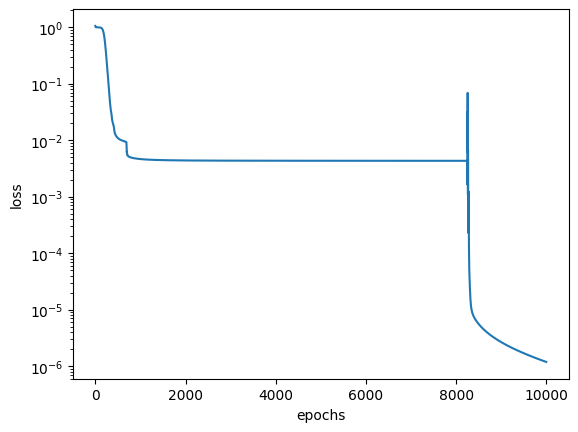

In [70]:
plt.plot(np.arange(num_steps), loss_data)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('log')

In [ ]:
torch.nn.MSELoss()(sign_mid_mlp(sign_dataset_mid['train_input']).round(), sign_dataset_mid['train_label'].to(dtype=torch.float32)) # also no mistakes

tensor(0., grad_fn=<MseLossBackward0>)

In [71]:
torch.save(sign_mid_mlp.state_dict(), 'models/mlp_j2_0.6024.pt')

In [77]:
test_load_mlp = nn.Sequential(*layers)
test_load_mlp.load_state_dict(torch.load('models/mlp_j2_0.6024.pt', weights_only=True))
test_load_mlp.eval()

Sequential(
  (0): Linear(in_features=12, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): Tanh()
  (6): Linear(in_features=32, out_features=1, bias=True)
  (7): Tanh()
)

In [78]:
torch.nn.MSELoss()(test_load_mlp(sign_dataset_mid['train_input']), sign_dataset_mid['train_label'].to(dtype=torch.float32))

tensor(1.1889e-06, grad_fn=<MseLossBackward0>)

In [84]:
torch.save(sign_mid_mlp, 'models/mlp_j2_0.6024_full.pt')

In [85]:
# test_load_mlp_2 = nn.Sequential()
test_load_mlp_2 = torch.load('models/mlp_j2_0.6024_full.pt', weights_only=False)
test_load_mlp_2.eval()

Sequential(
  (0): Linear(in_features=12, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): Tanh()
  (6): Linear(in_features=32, out_features=1, bias=True)
  (7): Tanh()
)

In [86]:
torch.nn.MSELoss()(test_load_mlp_2(sign_dataset_mid['train_input']), sign_dataset_mid['train_label'].to(dtype=torch.float32))

tensor(1.1889e-06, grad_fn=<MseLossBackward0>)

In [87]:
J2s = 1/ np.linspace(0 + 2 / 100, 2, 100)
J2s[:5]

array([50.        , 25.        , 16.66666667, 12.5       , 10.        ])

In [95]:
mlp_losses = []
mlp_accuracies = []
kan_losses = []
kan_accuracies = []
for J2 in J2s:
    print(J2)
    gs = qt.qload(f'../J1J2_info/large_J2/N{N}/n{N}gs_J2_{round(J2, 4)}')
    states, signs = utils.get_nonzero_states(N, gs, 1e-10)
    input = utils.generate_input_samples(N, states)
    reim_input = []
    for x in input: 
        reims = []
        ft = rfft(x)
        for c in ft:
            reims.append(c.real)
            reims.append(c.imag)
        reim_input.append(reims)
    reim_input = torch.tensor(reim_input)
    sign_label = torch.tensor(signs).reshape(-1, 1)
    
    kan_loss1 = torch.sqrt(((sign_mid_kan(reim_input) - sign_label)**2).mean()).item()
    kan_loss2 = torch.sqrt(((sign_mid_kan(reim_input) + sign_label)**2).mean()).item()
    kan_acc1 = (sign_mid_kan(reim_input).round() == sign_label).sum() / len(states)
    kan_acc2 = (sign_mid_kan(reim_input).round() == -1 * sign_label).sum() / len(states)
    kan_losses.append(min(kan_loss1, kan_loss2))
    kan_accuracies.append(max(kan_acc1, kan_acc2))

    mlp_loss1 = torch.nn.MSELoss()(sign_mid_mlp(reim_input), sign_label.to(dtype=torch.float32)).item()
    mlp_loss2 = torch.nn.MSELoss()(sign_mid_mlp(reim_input), -1 * sign_label.to(dtype=torch.float32)).item()
    mlp_acc1 = (sign_mid_mlp(reim_input).round() == sign_label).sum() / len(states)
    mlp_acc2 = (sign_mid_mlp(reim_input).round() == -1 * sign_label).sum() / len(states)
    mlp_losses.append(min(mlp_loss1, mlp_loss2))
    mlp_accuracies.append(max(mlp_acc1, mlp_acc2))
# 30s

50.0
25.0
16.666666666666668
12.5
10.0
8.333333333333332
7.142857142857143
6.25
5.555555555555555
5.0
4.545454545454546
4.166666666666667
3.846153846153846
3.571428571428571
3.333333333333333
3.125
2.941176470588235
2.7777777777777772
2.6315789473684212
2.5
2.380952380952381
2.272727272727273
2.1739130434782608
2.083333333333333
2.0
1.923076923076923
1.8518518518518516
1.7857142857142856
1.7241379310344827
1.6666666666666667
1.6129032258064517
1.5625
1.5151515151515151
1.4705882352941175
1.4285714285714284
1.3888888888888886
1.3513513513513513
1.3157894736842106
1.282051282051282
1.25
1.2195121951219512
1.1904761904761905
1.1627906976744187
1.1363636363636365
1.1111111111111112
1.0869565217391304
1.0638297872340425
1.0416666666666665
1.0204081632653061
1.0
0.9803921568627451
0.9615384615384615
0.9433962264150942
0.9259259259259258
0.9090909090909091
0.8928571428571428
0.8771929824561403
0.8620689655172413
0.8474576271186441
0.8333333333333334
0.819672131147541
0.8064516129032259
0.7936

In [96]:
mlp_accuracies

[tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.9221),
 tensor(0.9221),
 tensor(0.9221

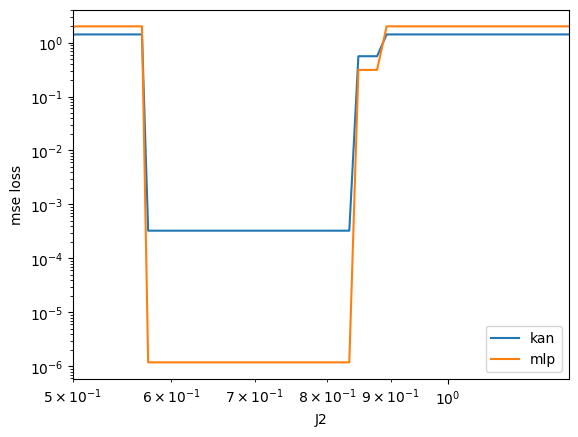

In [106]:
plt.plot(J2s, kan_losses, label='kan')
plt.plot(J2s, mlp_losses, label='mlp')
plt.legend(loc = 'best')
plt.ylabel('mse loss')
plt.xlabel('J2')
plt.xscale('log')
plt.xlim(0.5, 1.25)
plt.yscale('log')
plt.show()

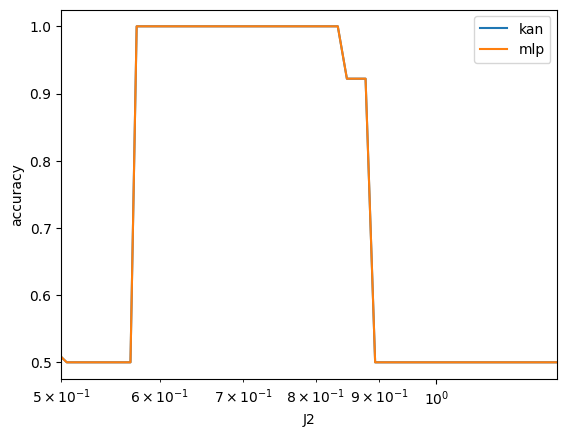

In [107]:
plt.plot(J2s, kan_accuracies, label='kan')
plt.plot(J2s, mlp_accuracies, label='mlp')
plt.legend(loc = 'best')
plt.ylabel('accuracy')
plt.xlabel('J2')
plt.xscale('log')
plt.xlim(0.5, 1.25)
plt.show()

In [ ]:
states_set, signs_set = utils.get_nonzero_states(N, qt.qload('../J1J2_info/large_J2/N12/n12gs_J2_0.6024'), 1e-10)


[]

In [121]:
set_J2 = 0.6024
states_set, signs_set = utils.get_nonzero_states(N, qt.qload('../J1J2_info/large_J2/N12/n12gs_J2_0.6024'), 1e-10)
states_set, signs_set = np.array(states_set), np.array(signs_set)
nnz = []
devs_J2 = []
sign_devs = []
for J2 in J2s:
    states, signs = utils.get_nonzero_states(N, qt.qload(f'../J1J2_info/large_J2/N12/n12gs_J2_{round(J2, 4)}'), 1e-10)
    states, signs = np.array(states), np.array(signs)
    nnz.append(len(states))
    if J2 <= 0.8 and J2 >= 0.6: 
        devs_J2.append(J2)
        sign_devs.append(max((signs_set == signs).sum(), (signs_set == -1 * signs).sum()))

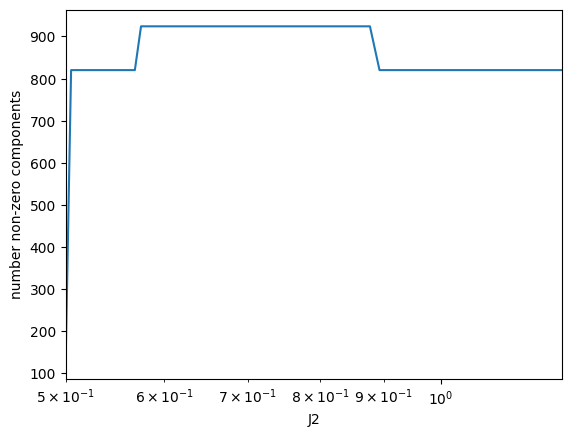

In [124]:
plt.plot(J2s, nnz)
plt.xscale('log')
plt.xlim(0.5, 1.25)
plt.xlabel('J2')
plt.ylabel('number non-zero components')
plt.show()

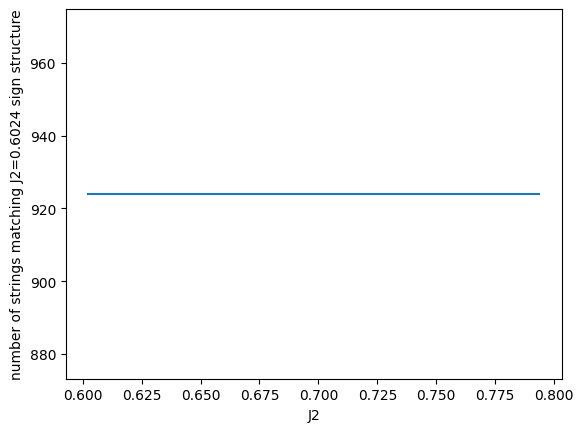

: 

In [ ]:
plt.plot(devs_J2, sign_devs)
plt.ylabel('number of strings matching J2=0.6024 sign structure')
plt.xlabel('J2')
plt.show()